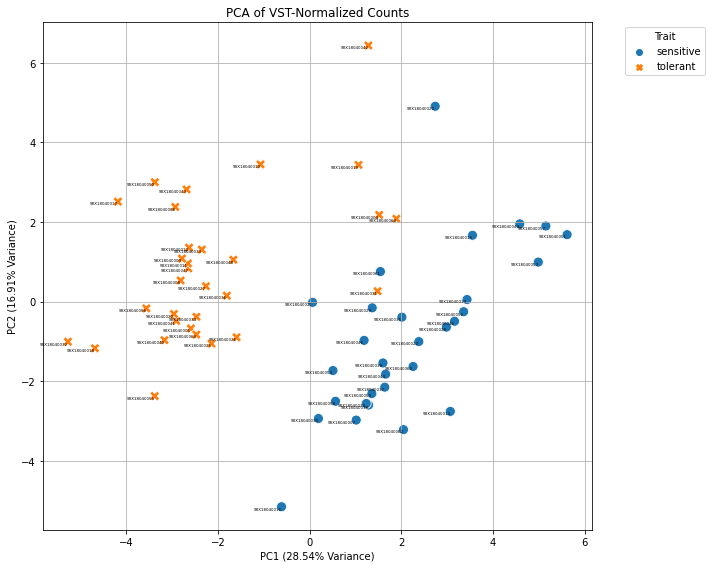

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


# Replace with the correct paths to your files
gene_counts = pd.read_csv("../data/rnaseq_gene_counts/vst_ctrlDEseq2filt_dataset1.tsv", sep='\t')
metadata = pd.read_csv("../data/merged_metadata.csv")

# Simplify metadata for alignment
metadata.rename(columns={'Experiment': 'Sample'}, inplace=True)

# Align gene counts with metadata
gene_count_samples = set(gene_counts.columns[1:])
metadata_samples = set(metadata['Sample'])
aligned_gene_counts = gene_counts[['gene_id'] + list(gene_count_samples.intersection(metadata_samples))]


# Transpose the data for PCA (genes as features, samples as rows)
pca_data = aligned_gene_counts.drop(columns='gene_id').T

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.log10(pca_data + 1))  # Log-transform CPM values

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='Trait',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of VST-Normalized Counts')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
# Save the PCA plot
plt.savefig("../analyses/DiffAbundStepwise_pca_ds1.png")
plt.show()


